### Import the required packages

In [3]:
import psycopg2
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import json

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.grid_search import RandomizedSearchCV

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Connect to the database

In [4]:
#Define the connection variables
host = 'production-bi-data-slave-1.psql.db.outfittery.de'
dbname = 'dwh'
user = 'ml'
pw = '<xBqWW1X~6dfwEh'

In [5]:
# Create the full connection string
conn_string = 'host=' + host + ' dbname=' + dbname + ' user=' + user + ' password=' + pw

# Print the connection string
print('Connecting to database\n{0}'.format(conn_string))

# Get the connection object
conn = psycopg2.connect(conn_string)

# Get the cursor object that we can run queries on
cursor = conn.cursor()
print('Connected!\n')

Connecting to database
host=production-bi-data-slave-1.psql.db.outfittery.de dbname=dwh user=ml password=<xBqWW1X~6dfwEh
Connected!



### Get the data from the database

In [6]:
colnames = ['customer_id', 'case_id_key', 'date_observed', 'case_number', 'days_since_last_order', 'avg_nsb4ret', 'avg_cogb4ret', 'avg_nsexp', 'avg_cog_exp', 'avg_cm1', 'avg_cm2', 'avg_cm3', 'overall_discount_perc', 'overall_goodwill_perc', 'overall_voucher_perc', 'cm1_before_canc_after_returns', 'value'] #, 'case_cm1', 'case_cm2', 'case_cm3']
db_table = 'ml.ecdc_modeling_table_v0'


In [7]:
my_query = "select " + ','.join(colnames) + " from " + db_table + " where value is not null limit 10000"

# execute our Query
cursor.execute(my_query)
print('Executed Query')

# retrieve the records from the database

records = pd.DataFrame(cursor.fetchall(), columns = colnames)
print('Retrieved Records')

Executed Query
Retrieved Records


In [8]:
original_cols = colnames.copy()
original_cols.remove('value')

import json
def row_mapper(row):
    
    original_series = pd.Series({colname: row[colname] for colname in original_cols}) 
    json_dict = json.loads(row['value'])
    json_dict.pop('date_observed',None)
    json_dict.pop('customer_id',None)
    agg_series = pd.Series(json_dict)
    
    ret_series = pd.concat([original_series, agg_series])
    
    return ret_series

data = records.apply(row_mapper, axis = 1)

In [9]:
data = data.convert_objects(convert_numeric = True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
avg_cm1                              10000 non-null float64
avg_cm2                              10000 non-null float64
avg_cm3                              10000 non-null float64
avg_cog_exp                          10000 non-null float64
avg_cogb4ret                         10000 non-null float64
avg_nsb4ret                          10000 non-null float64
avg_nsexp                            10000 non-null float64
case_id_key                          10000 non-null int64
case_number                          10000 non-null int64
cm1_before_canc_after_returns        10000 non-null float64
customer_id                          10000 non-null int64
date_observed                        10000 non-null datetime64[ns]
days_since_last_order                10000 non-null float64
overall_discount_perc                10000 non-null float64
overall_goodwill_perc                10000 non-null

### Impute the missing values 
* Note: Just deleting rows for now - implement later
* Use MICE
* See: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/

In [11]:
'''import skmice
from sklearn.linear_model import LinearRegression

imputer = MiceImputer()

data,specs = imputer.transform(data, LinearRegression, 5)

print(specs)'''


data = data.dropna()

### Plot the correlation matrix

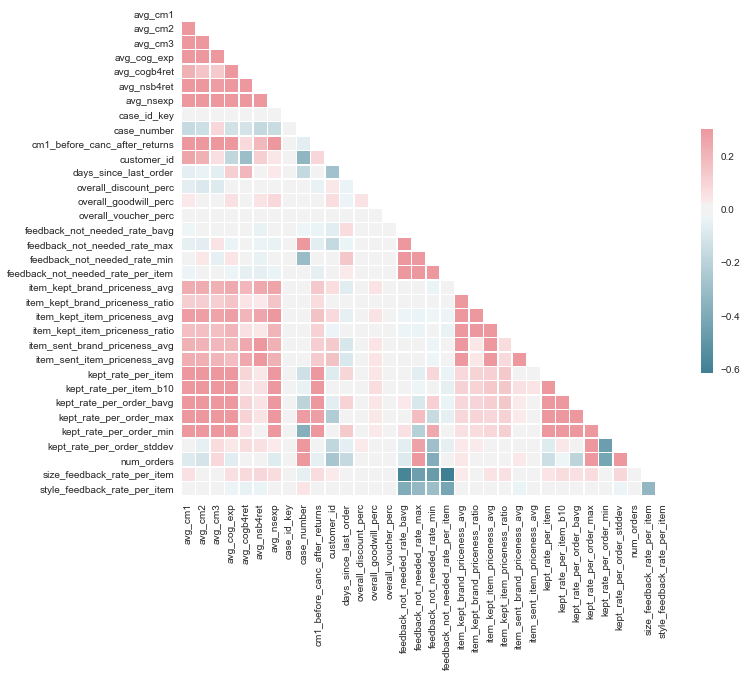

In [12]:
import seaborn as sns
sns.set(style="white")
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Testing snsplot

In [13]:
'''g = sns.PairGrid(data.iloc[:,:10])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);'''

'g = sns.PairGrid(data.iloc[:,:10])\ng.map_diag(sns.kdeplot)\ng.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);'

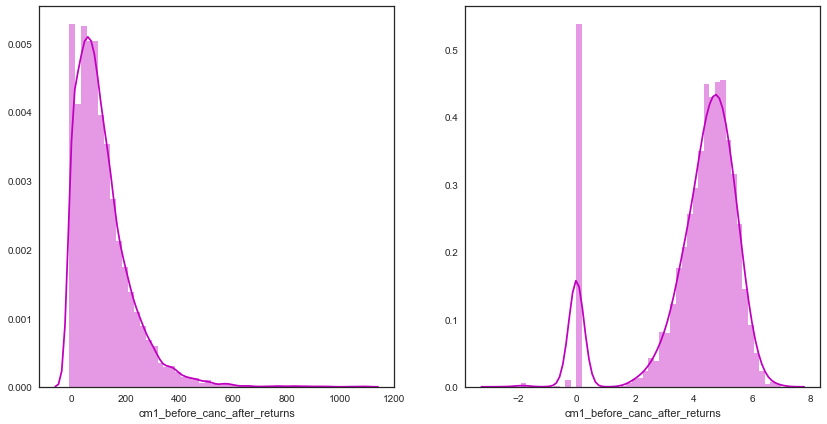

In [14]:
f, axes = plt.subplots(1, 2, figsize=(14,7))
sns.distplot(data['cm1_before_canc_after_returns'], color="m", ax=axes[0])
sns.distplot(np.sign(data['cm1_before_canc_after_returns']) * np.log(abs(data['cm1_before_canc_after_returns']) + 1), \
             color="m", ax=axes[1])

### Split the data into train, test sets
* Note: Just removing any CM1 values <= 0 for now.
* Fix this later

In [15]:
from sklearn.model_selection import train_test_split

data = data[data['cm1_before_canc_after_returns'] > 0]

non_modeling_cols = ['cm1_before_canc_after_returns','case_id_key','case_number','customer_id','date_observed']
y = np.log(data['cm1_before_canc_after_returns'])
X = data.drop(non_modeling_cols, axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Create the error functions
* Kendall rank coefficient: https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient
* Rank weighted MSE

In [16]:
from sklearn.metrics.scorer import make_scorer
from scipy.stats import kendalltau

def kendall_rank(y, y_pred, X, cm_col = 'case_cm1'):
    '''
    Returns the Kendall rank coefficient for our data sorted by cm1 vs sorted by y_pred.
    See this link for more details:
    https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient
    
    @Paramaters:
    y: This is the 'ground truth' for the y values
        It's not used here as we are scoring based on rank rather than by comparing predicted values with their real ones
        It's required as a paramater by the make_scorer function from sklearn
        
    y_pred: our predicted y values
    
    X: The X values that were used to predict the y vector
    
    '''
    
    return kendalltau(X[cm_col], y_pred)[0]


def rank_weighted_mse(y, y_pred, X, cm_col = 'case_cm1'):
    '''
    Returns the Rank weighted MSE for our data sorted by cm1 vs sorted by y_pred.
    This is the MSE of CM1 weighted by (N-Rank)
    
    @Paramaters:
    y: This is the 'ground truth' for the y values
        It's not used here as we are scoring based on rank rather than by comparing predicted values with their real ones
        It's required as a paramater by the make_scorer function from sklearn
        
    y_pred: our predicted y values
    
    X: The X values that were used to predict the y vector
    
    '''

    
    base_cm1 = X[cm_col][np.argsort(X[cm_col])].reset_index(drop = True).astype('float')
    custom_rank_cm1 = X[cm_col][np.argsort(y_pred)].reset_index(drop = True).astype('float')
    
    
    numerator = 0.
    N = len(base_cm1)
    i = 0
    
    for base, custom in zip(base_cm1, custom_rank_cm1):
        i+=1
        numerator += (N-i)  * (base - custom) ** 2
        
    denominator = (N/2) * (N+1)
    
    mse = np.sqrt(numerator/denominator)
        
    
    return mse


kendall_rank_scorer = make_scorer(kendall_rank, greater_is_better=True, X = X_test)
rw_mse_error = make_scorer(rank_weighted_mse, greater_is_better=False, X = X_test)

### Fit some basic models to the data

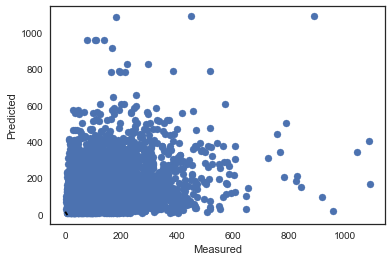

CART: 165.128970


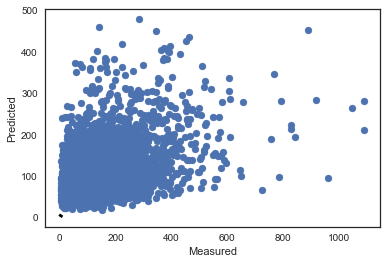

RF: 112.612174


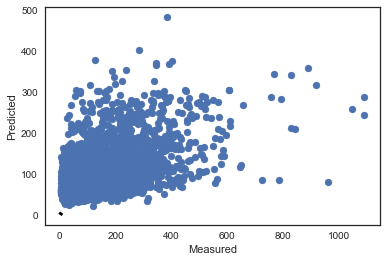

GBM: 107.789838


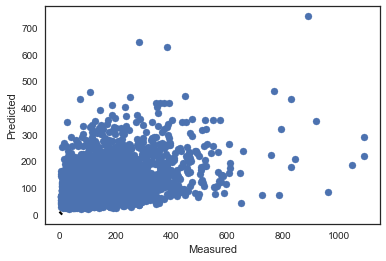

KNN: 114.967311


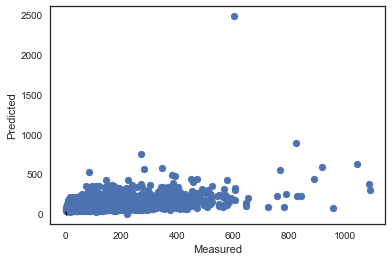

Ridge: 114.986165


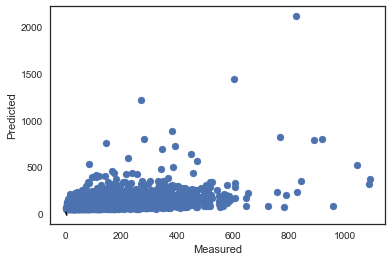

Lasso: 115.960708


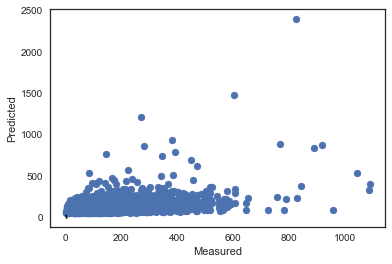

ElasticNet: 118.071795


In [17]:

models = []
models.append(('CART', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('GBM', GradientBoostingRegressor()))
models.append(('KNN', neighbors.KNeighborsRegressor()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))

# evaluate each model in turn
results_in = []
names_in = []

for name, model in models:
    
    predicted = cross_val_predict(model, X_train, y_train, cv=3)

    fig, ax = plt.subplots()
    ax.scatter(np.exp(y_train), np.exp(predicted))
    ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    #test_results = model.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(np.exp(predicted), y_train))
    results_in.append(rmse)
    names_in.append(rmse)
    msg = "%s: %f" % (name, rmse)
    print(msg)

-0.5806944648935848
{'max_depth': 7, 'min_samples_split': 12, 'n_estimators': 61}


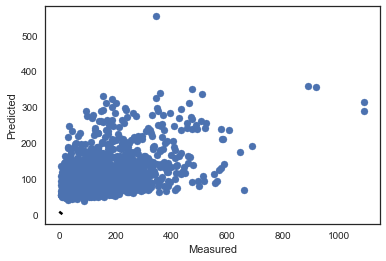

In [159]:
#Use 5 fold cross validation and a grid search to optimize the paramaters
rf = RandomForestRegressor()

param_grid = {
              'n_estimators': scipy.stats.randint(3, 100),
              'min_samples_split': scipy.stats.randint(2, 50),
              'max_depth': scipy.stats.randint(1, 12)
            }

rs = RandomizedSearchCV(rf, param_grid, n_jobs=1, cv=3,n_iter = 20, scoring = 'neg_mean_absolute_error')  
rs.fit(X_train, y_train)  
print(rs.best_score_)
print(rs.best_params_)

preds = rs.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(np.exp(y_test), np.exp(preds))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [18]:
np.sqrt(mean_squared_error(np.exp(preds), y_test))

NameError: name 'preds' is not defined

In [19]:
sns.residplot(y_test, preds, lowess=True, color="g")

NameError: name 'preds' is not defined

### Look at the most important features

In [20]:
final_model = rs.best_estimator_
final_model.fit(X_train, y_train)

var_names = X_train.columns.values
importances = final_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_model.estimators_],
 axis=0)
indices = np.argsort(importances)


# Plot the feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(X_train.shape[1]), importances[indices],
   color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train.shape[1]), var_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

NameError: name 'rs' is not defined

# Linear Regression
1. Manually implemented
2. Ridge
3. Lasso
4. ElasticNet

### 1. Manual implementation
1. Check each variable individually
2. Create model with all potentiall significant (p-value > 0.2) variables
3. Try add in non selected variables
4. Try add in all possible interactions

* Plot the distribution of all variables and see which ones need tranformation to make normal

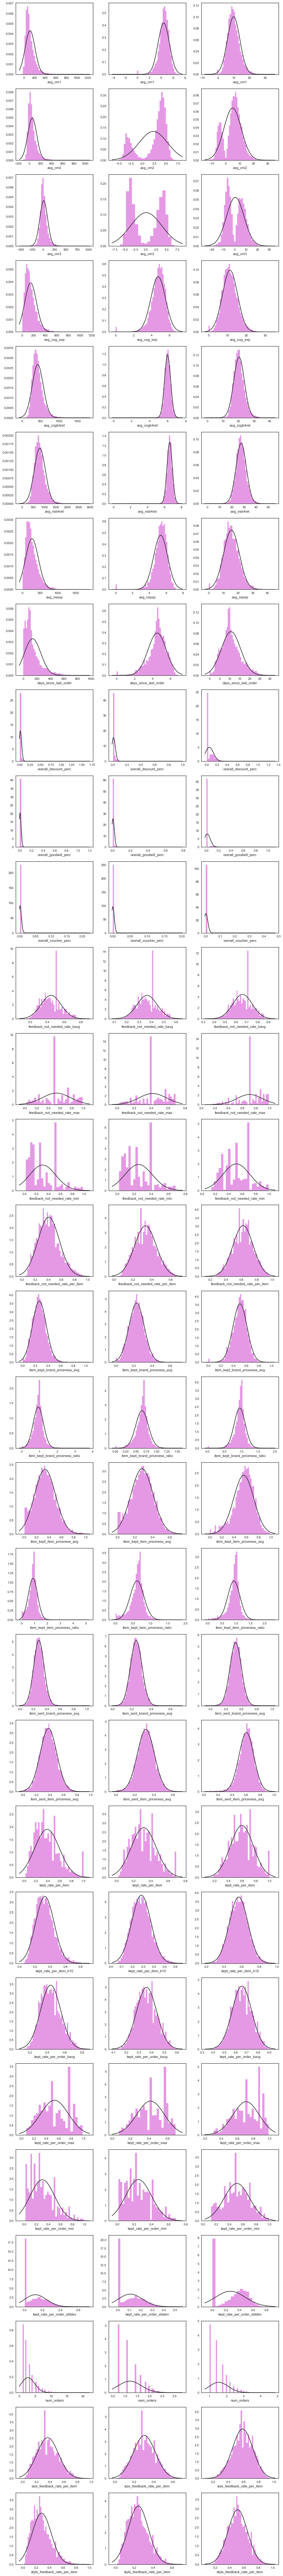

In [21]:
def log_transform(x):
    return np.sign(x) * np.log(abs(x) + 1)

def sqrt_transform(x):
    return np.sign(x) * np.sqrt(abs(x))


def var_plot(x, axes):
    sns.distplot(x, color = 'm', ax = axes[0], kde=False, fit=scipy.stats.norm)
    sns.distplot(log_transform(x), color = 'm', ax = axes[1], kde=False, fit=scipy.stats.norm)
    sns.distplot(sqrt_transform(x), color = 'm', ax = axes[2], kde=False, fit=scipy.stats.norm)


    
ncols = X.shape[1]
f, axes = plt.subplots(ncols, 3, figsize=(15,5*ncols))
for i in range(ncols):
    col = X.columns[i]
    var_plot(X[col], axes[i,:])

In [166]:
data.columns

Index(['avg_cm1', 'avg_cm2', 'avg_cm3', 'avg_cog_exp', 'avg_cogb4ret',
       'avg_nsb4ret', 'avg_nsexp', 'case_id_key', 'case_number',
       'cm1_before_canc_after_returns', 'customer_id', 'date_observed',
       'days_since_last_order', 'overall_discount_perc',
       'overall_goodwill_perc', 'overall_voucher_perc',
       'feedback_not_needed_rate_bavg', 'feedback_not_needed_rate_max',
       'feedback_not_needed_rate_min', 'feedback_not_needed_rate_per_item',
       'item_kept_brand_priceness_avg', 'item_kept_brand_priceness_ratio',
       'item_kept_item_priceness_avg', 'item_kept_item_priceness_ratio',
       'item_sent_brand_priceness_avg', 'item_sent_item_priceness_avg',
       'kept_rate_per_item', 'kept_rate_per_item_b10',
       'kept_rate_per_order_bavg', 'kept_rate_per_order_max',
       'kept_rate_per_order_min', 'kept_rate_per_order_stddev', 'num_orders',
       'size_feedback_rate_per_item', 'style_feedback_rate_per_item'],
      dtype='object')